# Install and import used dependancies

In [1]:
!pip install scikit-learn==1.5.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Read and peek into the data and seperate the label

In [3]:
housing_data = pd.read_csv("/kaggle/input/california-housing-data/housing.csv")
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can see that (except for `ocean_proximity`) all features are contineous numerical values, they look like they might need some scaling, but let's do some work first

In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` feature might be entirely removed or imputed, again, we'll have to do some work before we decide that

In [5]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Data Visualizations

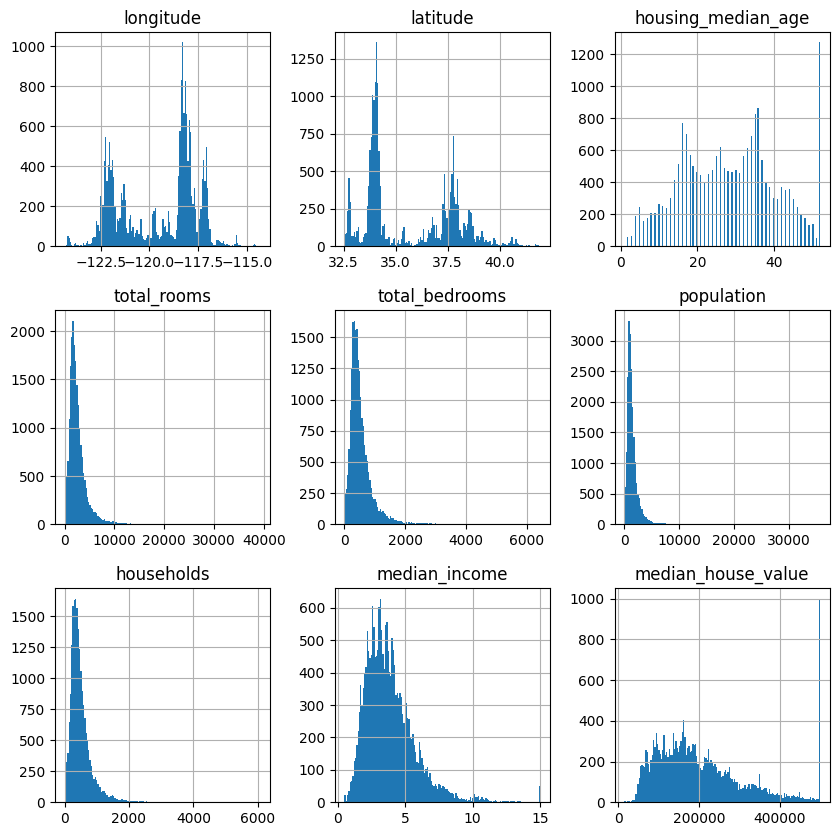

In [6]:
housing_data.hist(bins=150, figsize=(10, 10))
plt.show()

Looks like most features are skewed right, and they indeed are in massive need of scaling.

We can also see a massive spike in the largest value in both `median_house_value` and `housing_median_age`, which indicates that they are capped at those values (either that or cali has some really old expensive houses)

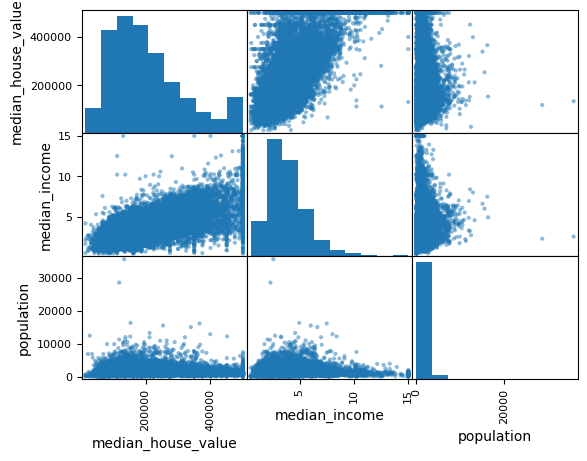

In [7]:
pd.plotting.scatter_matrix(housing_data[["median_house_value", "median_income", "population"]])
plt.show()

Seems like `median_income` might be strongly correlated to the target variable

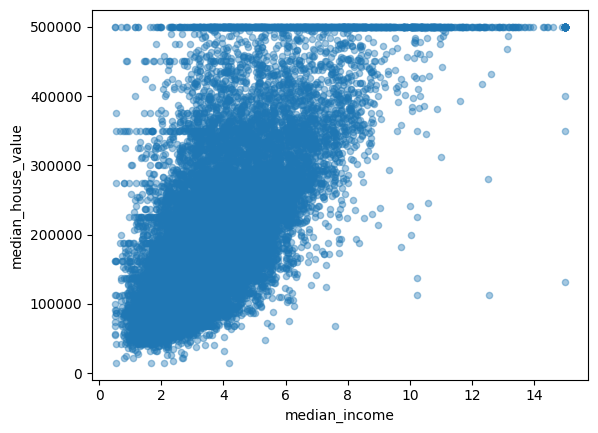

In [8]:
housing_data.plot.scatter(x="median_income", y="median_house_value", alpha=0.4)
plt.show()

So far, it seems like `median_income` is linearly related to `median_house_value`, in other words, as the income increases, the price of the household increases (except in some instances like the (500K, 450K, 350K, 280K) points, some other less obvious places as well)

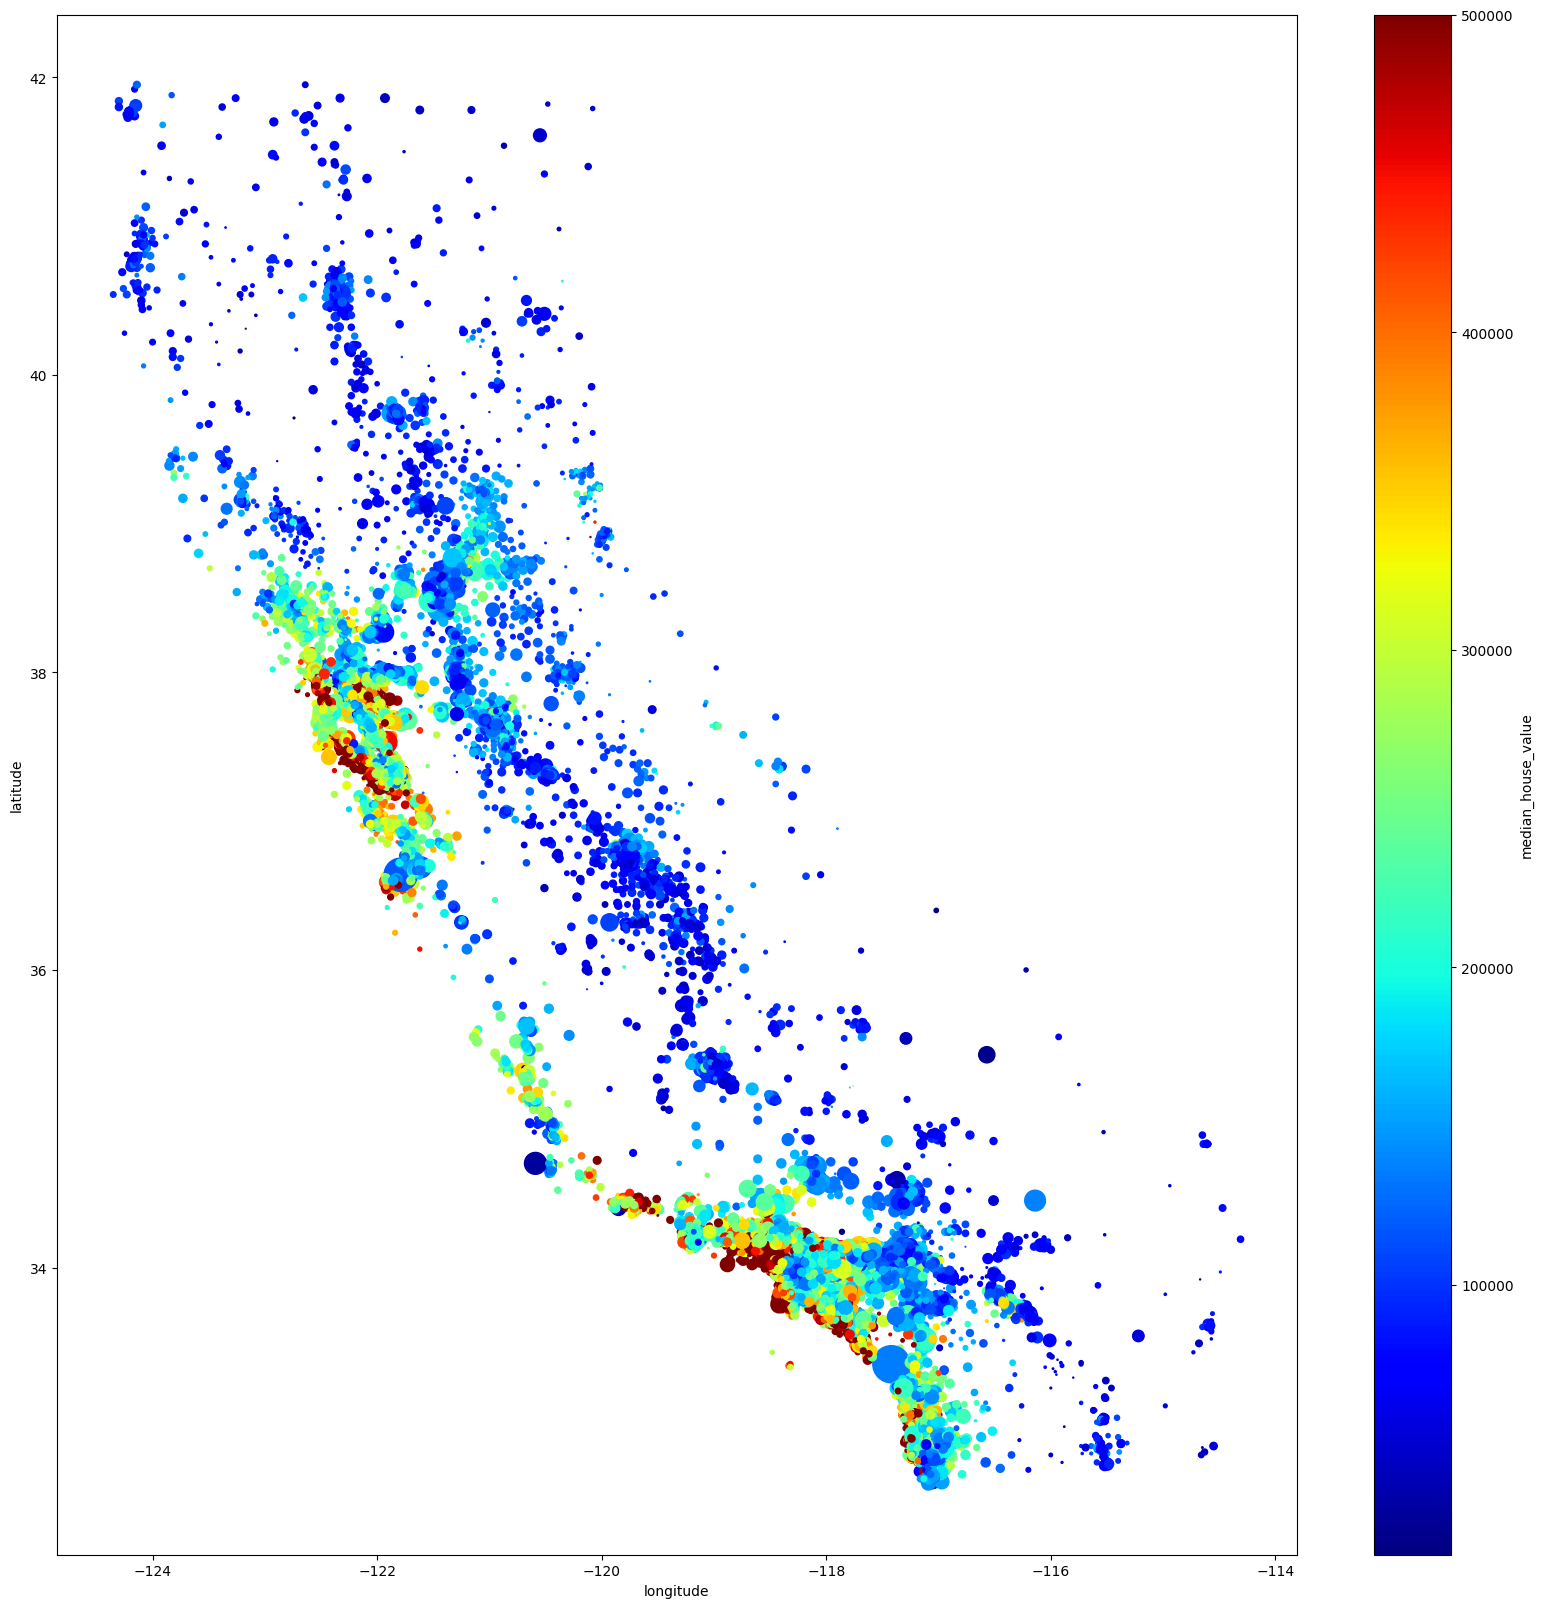

In [9]:
housing_data.plot.scatter(x="longitude", y="latitude", s=housing_data[["population"]]/50, c="median_house_value",
                          colormap="jet", figsize=(20, 20))
plt.show()

This draws California's map.

Houses near the ocean are more expensive than those further away (except northern california), population doesn't have that big of an empact on the price though

First thing first, let's make the split

# Train-Test Split

In [10]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)

In [11]:
train_set_labels = train_set["median_house_value"]
train_set.drop("median_house_value", inplace=True, axis=1)

# Data Preprocessing

From what was revealed, we need:
- Scale the data
- Deal with the heavy-tailed features
- Impute missing data
- Encode categorical data

In [12]:
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), FunctionTransformer(np.log, feature_names_out="one-to-one"),
                             StandardScaler())

In [13]:
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder())

In [14]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [15]:
preprocessing = ColumnTransformer(
    [("num", num_pipeline, ["population", "households", "median_income"]),
     ("cat", cat_pipeline, ["ocean_proximity"])],
    remainder=default_num_pipeline)

In [16]:
train_set_preped = preprocessing.fit_transform(train_set)

In [17]:
training_set = pd.DataFrame(train_set_preped, columns=preprocessing.get_feature_names_out(), index=train_set.index)

array([[<Axes: title={'center': 'num__population'}>,
        <Axes: title={'center': 'num__households'}>,
        <Axes: title={'center': 'num__median_income'}>,
        <Axes: title={'center': 'cat__ocean_proximity_<1H OCEAN'}>],
       [<Axes: title={'center': 'cat__ocean_proximity_INLAND'}>,
        <Axes: title={'center': 'cat__ocean_proximity_ISLAND'}>,
        <Axes: title={'center': 'cat__ocean_proximity_NEAR BAY'}>,
        <Axes: title={'center': 'cat__ocean_proximity_NEAR OCEAN'}>],
       [<Axes: title={'center': 'remainder__longitude'}>,
        <Axes: title={'center': 'remainder__latitude'}>,
        <Axes: title={'center': 'remainder__housing_median_age'}>,
        <Axes: title={'center': 'remainder__total_rooms'}>],
       [<Axes: title={'center': 'remainder__total_bedrooms'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

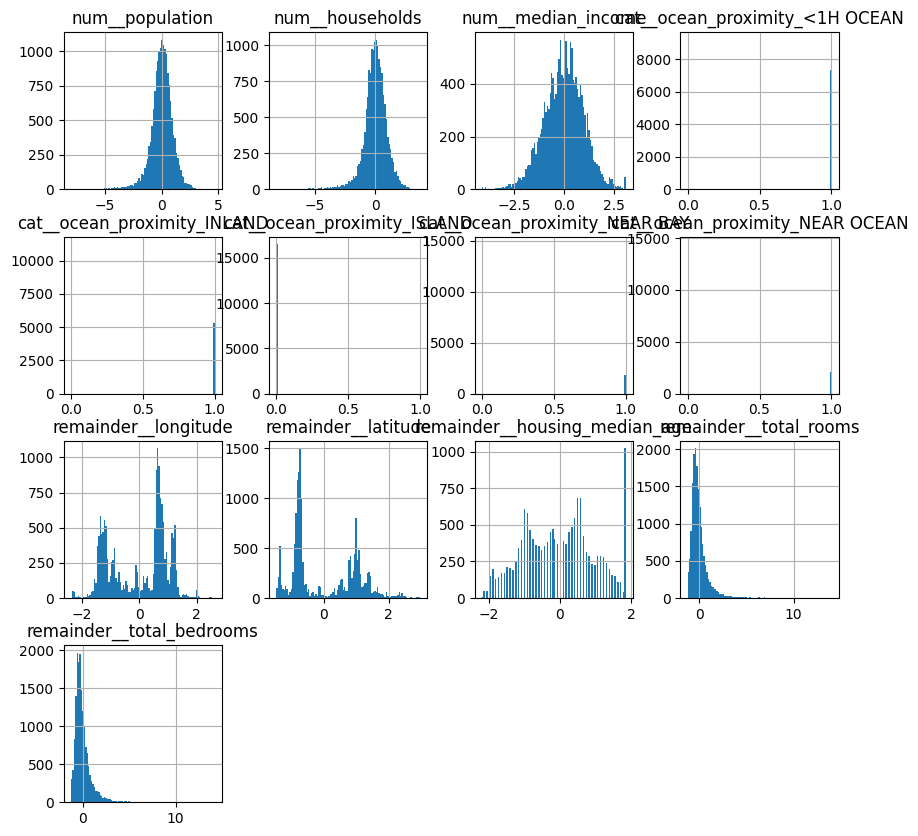

In [18]:
training_set.hist(bins=100, figsize=(10, 10))

# Model Selection

Let's try out a couple of models that i think will preform decently well on this task

In [19]:
# Let's start with a linear regression  model
lin_reg = LinearRegression()
lin_reg.fit(training_set, train_set_labels)
lin_pred = lin_reg.predict(training_set)
lin_pred

array([293881.50324079, 220274.55048548, 281937.39449568, ...,
        97713.46738308,  99539.94350878, 297431.21221173])

In [20]:
train_set_labels

14196    291000.0
8267     156100.0
17445    353900.0
14265    241200.0
2271      53800.0
           ...   
11284     71600.0
11964    379300.0
5390     104200.0
860       84700.0
15795    251400.0
Name: median_house_value, Length: 16512, dtype: float64

In [21]:
root_mean_squared_error(train_set_labels, lin_pred)

71609.77567056114

That...is not really good, let's try another model

In [22]:
# Decision Tree
tree = DecisionTreeRegressor()
tree.fit(training_set, train_set_labels)
tree_pred = tree.predict(training_set)

In [23]:
root_mean_squared_error(tree_pred, train_set_labels)

0.0

Well...that doesn't seem right, it most likely overfit the data, let's try cross-validation

In [24]:
tree_rmse = -cross_val_score(tree, training_set, train_set_labels, cv=10, scoring="neg_root_mean_squared_error")

In [25]:
np.mean(tree_rmse)

67981.00380609313

Seems more like it.

This model is much better than the linear regression model, however i still think it's not acceptable performance, especially that this is only cross validation so most likely it will perform much worse on the actual test set, let's try out one more model

In [26]:
# Random Forest
rndm = RandomForestRegressor()
rndm.fit(training_set, train_set_labels)

RandomForestRegressor()

In [27]:
rndm_rmse = -cross_val_score(rndm, training_set, train_set_labels, cv=10, scoring="neg_root_mean_squared_error")
np.mean(rndm_rmse)

48737.39192748137

So far this seems to be the best performing model, and i personally believe it's promising to be something good, but let's do some tuning first

# Fine-Tuning

In [28]:
full_pipeline = Pipeline([("pre", preprocessing), ("random_forest", RandomForestRegressor(random_state=42))])

param_grid=[{"pre__num__simpleimputer__strategy":["mean", "median"], "random_forest__max_features":[6, 8, 10, 12]},
            {"pre__num__simpleimputer__strategy":["mean", "median"], "random_forest__max_features":[8, 10, 12, 14]}]

grid_search = GridSearchCV(full_pipeline, param_grid=param_grid, cv=3, scoring="neg_root_mean_squared_error")

In [29]:
grid_search.fit(train_set, train_set_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func...
                                                                                          OneHotEncoder())]),
                                                                         ['ocean_proximity'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'pre__num__simpleimputer__strategy': ['mean',
                                                                'median'],
                          'random_forest__max_features': [6, 8, 10, 12]},
                         {'pre__num__simpleimputer__strategy': ['mean',
                                                                'median'],
                          'random_forest__max_features': [8, 10, 12, 14]}],
             scoring='neg_root_mean_squared_error')

In [30]:
# Get the best model and it's hyperparameters
final_model = grid_search.best_estimator_

Let's test out our new model!

In [31]:
final_cv_pred = final_model.predict(train_set)

In [32]:
final_cv_rmse = -cross_val_score(final_model, train_set, train_set_labels, cv=10, scoring="neg_root_mean_squared_error")
final_cv_rmse

array([47412.15119988, 48956.38835539, 48322.04297487, 46812.46104561,
       50131.45638768, 47511.13231724, 48516.69917264, 48175.8334066 ,
       49198.12693912, 47797.04304421])

In [33]:
X_test = test_set.drop("median_house_value", axis=1)
Y_test = test_set["median_house_value"]

In [34]:
final_model_rmse = -cross_val_score(final_model, X_test, Y_test, cv=10, scoring="neg_root_mean_squared_error")

In [36]:
np.mean(final_model_rmse)

55755.38597411783

Although not great performance, and the data might require more preprocessing to get better results, we can conclude that in this case, out of the three candidates we had for this task, `Reandom Forest` algorithm is the b